In [1]:
import numpy as np
import matplotlib.pyplot as plt
from resnet_attack_todo import ResnetPGDAttacker
from datasets import load_dataset
import datasets
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader

In [2]:
# Define the default parameters
DEFAULT_ALPHA = 2 / 255
DEFAULT_STEPS = 20
DEFAULT_BATCH_SIZE = 32
DEFAULT_BATCH_NUM = 20
SEED = 1234  # Manual seed for reproducibility

# Create a list of epsilon values between 8/255 and 1
EPSILON_VALUES = np.linspace(8/255, 0.99, 5)

# List to store accuracies for each epsilon value
adv_accuracies = []
accuracies = []

In [3]:
# Load the model
print('Loading model...')
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
preprocess = weights.transforms()

# Load and preprocess data
print('Loading data...')
ds = load_dataset("ILSVRC/imagenet-1k", split="train", streaming=True, trust_remote_code=True)
ds = load_dataset("ILSVRC/imagenet-1k", split= datasets.Split.TRAIN, streaming=True, trust_remote_code=True)

def preprocess_img(example):
    example['image'] = preprocess(example['image'])
    return example

# Filter out grayscale images
ds = ds.filter(lambda example: example['image'].mode == 'RGB')
ds = ds.map(preprocess_img)
ds = ds.shuffle(seed=SEED)
ds = ds.take(1281167 // DEFAULT_BATCH_SIZE + 1)  # Take a portion of the dataset



Loading model...
Loading data...


In [4]:
# Loop through each epsilon value and perform the PGD attack
for eps in EPSILON_VALUES:
    dset_loader = DataLoader(ds, batch_size=DEFAULT_BATCH_SIZE)
    attacker = ResnetPGDAttacker(model, dset_loader)

    print(f"=== Launching PGD attack with eps = {eps} ===")
    attacker.pgd_batch_attack(eps, DEFAULT_ALPHA, DEFAULT_STEPS, DEFAULT_BATCH_NUM)
    adv_acc = attacker.adv_acc
    acc = attacker.acc
    adv_accuracies.append(1-adv_acc)  # Store the adversarial accuracy
    accuracies.append(acc)  # Store the original accuracy
    print(f"eps {eps} => attack acc = {1- adv_acc} | original acc = {acc}")
    print()


=== Launching PGD attack with eps = 0.03137254901960784 ===


100%|██████████| 20/20 [01:23<00:00,  4.18s/it]


eps 0.03137254901960784 => attack acc = 0.978125 | original acc = 0.925

=== Launching PGD attack with eps = 0.27102941176470585 ===


100%|██████████| 20/20 [01:16<00:00,  3.81s/it]


eps 0.27102941176470585 => attack acc = 1.0 | original acc = 0.925

=== Launching PGD attack with eps = 0.510686274509804 ===


100%|██████████| 20/20 [01:15<00:00,  3.79s/it]


eps 0.510686274509804 => attack acc = 1.0 | original acc = 0.925

=== Launching PGD attack with eps = 0.750343137254902 ===


100%|██████████| 20/20 [01:16<00:00,  3.81s/it]


eps 0.750343137254902 => attack acc = 0.996875 | original acc = 0.925

=== Launching PGD attack with eps = 0.99 ===


100%|██████████| 20/20 [01:16<00:00,  3.83s/it]

eps 0.99 => attack acc = 0.9984375 | original acc = 0.925



Now plotting..


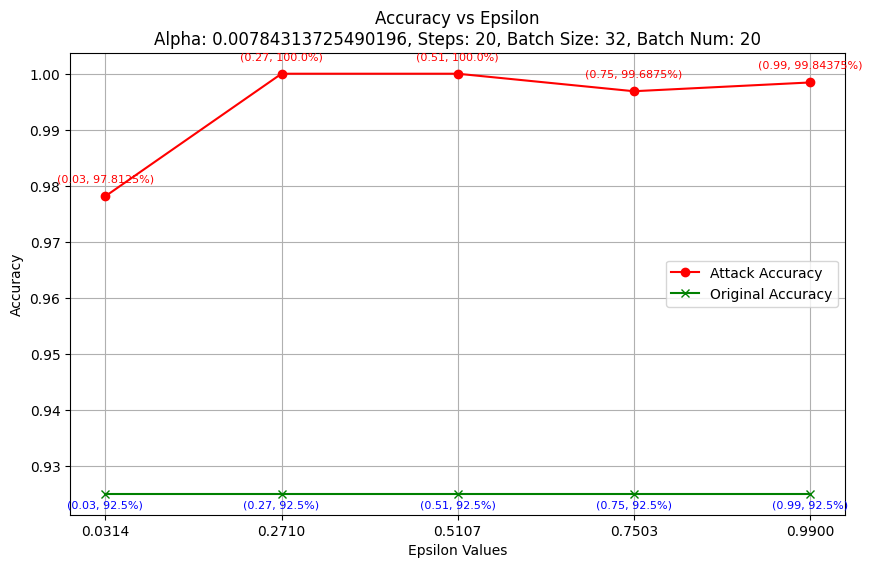

In [5]:

print("Now plotting..")
# Plotting the results
plt.figure(figsize=(10, 6))

# Plot adversarial accuracies
plt.plot(EPSILON_VALUES, adv_accuracies, marker='o', color='red', label='Attack Accuracy')

# Plot original accuracies
plt.plot(EPSILON_VALUES, accuracies, marker='x', color='green', label='Original Accuracy')

# Annotate points with x, y labels
for i, (eps, adv_acc, acc) in enumerate(zip(EPSILON_VALUES, adv_accuracies, accuracies)):
    plt.annotate(f'({eps:.2f}, {adv_acc * 100}%)', (eps, adv_acc), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='red')
    plt.annotate(f'({eps:.2f}, {acc * 100}%)', (eps, acc), textcoords="offset points", xytext=(0,-10), ha='center', fontsize=8, color='blue')

# Set plot title and labels
plt.title(f'Accuracy vs Epsilon\nAlpha: {DEFAULT_ALPHA}, Steps: {DEFAULT_STEPS}, Batch Size: {DEFAULT_BATCH_SIZE}, Batch Num: {DEFAULT_BATCH_NUM}')
plt.xlabel('Epsilon Values')
plt.ylabel('Accuracy')
plt.xticks(EPSILON_VALUES)  # Set x-ticks to the epsilon values
plt.grid()
plt.legend()
plt.savefig('adversarial_accuracy_vs_epsilon.png')
plt.show()